In [1]:
import sys
sys.path.append("trappy")

In [2]:
%matplotlib inline
import pandas as pd
import trappy
from collections import defaultdict

In [3]:
trappy.register_dynamic_ftrace("irq_handler_entry", "irq_handler_entry")
trappy.register_dynamic_ftrace("irq_handler_exit", "irq_handler_exit")

trappy.register_dynamic_ftrace("napi_gro_receive_entry", "napi_gro_receive_entry")
trappy.register_dynamic_ftrace("netif_receive_skb", "netif_receive_skb")

trappy.register_dynamic_ftrace("sys_enter_write", "sys_enter_write", parse_raw=True)
trappy.register_dynamic_ftrace("sys_exit_write", "sys_exit_write", parse_raw=True)

trappy.dynamic.sys_exit_write

In [4]:
trace = trappy.FTrace("trace.dat")

In [5]:
trace.sched_switch.data_frame.head()

__comm  __cpu  __line  __pid  next_comm  next_pid  next_prio  \
Time                                                                        
0.000000       wget      0       3   8435  swapper/0         0        120   
0.000283     <idle>      1       7      0  trace-cmd      8433        120   
0.000296  trace-cmd      1       9   8433  trace-cmd      8434        120   
0.000310  trace-cmd      1      11   8434  swapper/1         0        120   
0.000748     <idle>      1      14      0  rcu_sched         8        120   

          prev_comm  prev_pid  prev_prio  prev_state  
Time                                                  
0.000000  trace-cmd      8435        120           4  
0.000283  swapper/1         0        120           1  
0.000296  trace-cmd      8433        120           2  
0.000310  trace-cmd      8434        120           2  
0.000748  swapper/1         0        120           1

In [6]:
comm = "wget"

In [7]:
trace.sched_switch.data_frame[trace.sched_switch.data_frame.__comm == comm].head()

__comm  __cpu  __line  __pid     next_comm  next_pid  next_prio  \
Time                                                                       
0.000000   wget      0       3   8435     swapper/0         0        120   
0.002535   wget      0      29   8435     swapper/0         0        120   
0.005363   wget      0      44   8435     swapper/0         0        120   
0.008954   wget      0      69   8435  kworker/0:1H       164        100   
0.010624   wget      0      73   8435     swapper/0         0        120   

          prev_comm  prev_pid  prev_prio  prev_state  
Time                                                  
0.000000  trace-cmd      8435        120           4  
0.002535       wget      8435        120           4  
0.005363       wget      8435        120           4  
0.008954       wget      8435        120         256  
0.010624       wget      8435        120           4

In [8]:
trappy.plotter.plot_trace(trace)

In [9]:
trace_irq_entry = trappy.FTrace("trace.dat", scope="custom", events=["irq_handler_entry"])
trace_irq_exit = trappy.FTrace("trace.dat", scope="custom", events=["irq_handler_exit"])

In [10]:
trace_irq_entry.irq_handler_entry.data_frame.head()

__comm  __cpu  __line  __pid  irq                name
Time                                                           
0.002074  <idle>      1      17      0   21  ahci[0000:00:0d.0]
0.002137  <idle>      1      19      0   21        snd_intel8x0
0.003342  <idle>      1      30      0   21  ahci[0000:00:0d.0]
0.003399  <idle>      1      32      0   21        snd_intel8x0
0.005937  <idle>      1      45      0   21  ahci[0000:00:0d.0]

In [11]:
trace_irq_exit.irq_handler_exit.data_frame.head()

__comm  __cpu  __line  __pid  irq        ret
Time                                                  
0.002135  <idle>      1      18      0   21    handled
0.002221  <idle>      1      24      0   21  unhandled
0.003398  <idle>      1      31      0   21    handled
0.003438  <idle>      1      33      0   21  unhandled
0.006040  <idle>      1      46      0   21    handled

In [12]:
device = "enp0s3"

In [13]:
entry_dataframe = trace.irq_handler_entry.data_frame
device_irqs_entry = entry_dataframe[entry_dataframe['name'].str.contains(device)]

device_irq_numbers = device_irqs_entry['irq'].unique().tolist()
device_irq_numbers.sort()

exit_dataframe = trace.irq_handler_exit.data_frame
device_irqs_exit = exit_dataframe.loc[exit_dataframe['irq'].isin(device_irq_numbers)]
device_irqs_exit = device_irqs_exit.loc[device_irqs_exit['ret'] == 'handled']

In [14]:
device_irqs_entry.head()

__comm  __cpu  __line  __pid  irq    name
Time                                               
0.022756   <...>      1     230    611   19  enp0s3
0.023110   <...>      1     237    611   19  enp0s3
0.041152  <idle>      1     575      0   19  enp0s3
0.042414   <...>      1     596    611   19  enp0s3
0.052070  <idle>      1     712      0   19  enp0s3

In [15]:
device_irqs_exit.describe()

__cpu         __line         __pid      irq
count  30344.0   30344.000000  30344.000000  30344.0
mean       1.0  299845.268521    998.024486     19.0
std        0.0  168929.813717   2518.789656      0.0
min        1.0     231.000000      0.000000     19.0
25%        1.0  153298.750000      0.000000     19.0
50%        1.0  300814.000000      0.000000     19.0
75%        1.0  445891.500000      0.000000     19.0
max        1.0  594322.000000   8435.000000     19.0

In [16]:
irq_entry_dict = defaultdict()
irq_exit_dict = defaultdict()

for irq_num in device_irq_numbers:
    irq_entry_dict[irq_num] = device_irqs_entry[device_irqs_entry['irq'] == irq_num]

for irq_num in device_irq_numbers:
    irq_exit_dict[irq_num] = device_irqs_exit[device_irqs_exit['irq'] == irq_num]

irq_stats_dict = defaultdict()

for irq_num in device_irq_numbers:
    irq_entry_for_one = irq_entry_dict[irq_num]
    irq_exit_for_one = irq_exit_dict[irq_num]

    irq_entry_for_one = irq_entry_dict[irq_num]
    irq_exit_for_one = irq_exit_dict[irq_num]

    irq_stats_dict[irq_num] = irq_entry_for_one
    irq_stats = irq_stats_dict[irq_num]
    irq_stats['start'] = irq_entry_for_one.index.values
    irq_stats['end'] = irq_exit_for_one.index.values
    irq_stats['duration'] = irq_exit_for_one.index.values - irq_entry_for_one.index.values

for irq_num in device_irq_numbers:
    display(irq_entry_dict[irq_num].head())


__comm  __cpu  __line  __pid  irq    name     start       end  \
Time                                                                      
0.022756   <...>      1     230    611   19  enp0s3  0.022756  0.022780   
0.023110   <...>      1     237    611   19  enp0s3  0.023110  0.023130   
0.041152  <idle>      1     575      0   19  enp0s3  0.041152  0.041173   
0.042414   <...>      1     596    611   19  enp0s3  0.042414  0.042426   
0.052070  <idle>      1     712      0   19  enp0s3  0.052070  0.052086   

          duration  
Time                
0.022756  0.000024  
0.023110  0.000020  
0.041152  0.000021  
0.042414  0.000012  
0.052070  0.000016

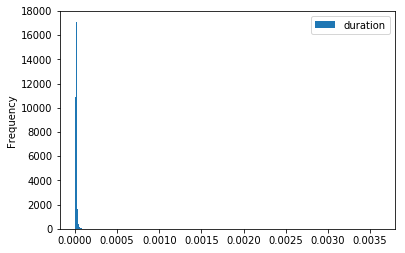

In [17]:
irq_stats_duration_dict = defaultdict()

for irq_num in device_irq_numbers:
    irq_stats_duration_dict[irq_num] = pd.DataFrame()
    irq_stats_duration_dict[irq_num]['duration'] = irq_stats_dict[irq_num]['duration']
    irq_stats_duration = irq_stats_duration_dict[irq_num]

    number_of_rows = irq_stats_duration.shape[0]
    number_of_columns = irq_stats_duration.shape[1]
    
irq_stats_duration = irq_stats_duration_dict[irq_num]
irq_stats_duration.plot.hist(bins=300)

In [18]:
device_irq_numbers = device_irqs_entry['irq'].unique().tolist()
device_irq_numbers.sort()

top_durations = pd.DataFrame()

for irq_num in device_irq_numbers:
    irq_stats = irq_stats_dict[irq_num]
    top_durations = irq_stats.sort_values('duration', ascending=False)

top_durations.head(10)

__comm  __cpu  __line  __pid  irq    name      start  \
Time                                                                   
6.087654        <idle>      1  195288      0   19  enp0s3   6.087654   
11.134123  gnome-shell      1  363301   2417   19  enp0s3  11.134123   
3.708071        <idle>      1  118725      0   19  enp0s3   3.708071   
1.843073          wget      1   61457   8435   19  enp0s3   1.843073   
15.921113       <idle>      1  530229      0   19  enp0s3  15.921113   
15.788281  gnome-shell      1  524882   2417   19  enp0s3  15.788281   
16.554737       <idle>      1  557810      0   19  enp0s3  16.554737   
1.746168          wget      1   57536   8435   19  enp0s3   1.746168   
15.328165       <idle>      1  508047      0   19  enp0s3  15.328165   
1.871709     trace-cmd      1   62530   8434   19  enp0s3   1.871709   

                 end  duration  
Time                            
6.087654    6.091262  0.003608  
11.134123  11.135949  0.001826  
3.708071    3.709889  0.001818  
1.843073    1.844229  0.001156  
15.921113  15.922206  0.001093  
15.788281  15.789275  0.000994  
16.554737  16.555269  0.000532  
1.746168    1.746689  0.000521  
15.328165  15.328633  0.000468  
1.871709    1.872149  0.000440

In [19]:
for irq_num in device_irq_numbers:
    print(irq_num)
    irq_stats = irq_stats_dict[irq_num]
    display(irq_stats.describe())
    print('\n')


19


__cpu         __line         __pid      irq         start  \
count  30344.0   30344.000000  30344.000000  30344.0  30344.000000   
mean       1.0  299843.958938    998.024486     19.0      9.083110   
std        0.0  168929.788739   2518.789656      0.0      5.050315   
min        1.0     230.000000      0.000000     19.0      0.022756   
25%        1.0  153297.750000      0.000000     19.0      4.568759   
50%        1.0  300813.000000      0.000000     19.0      9.117784   
75%        1.0  445890.250000      0.000000     19.0     13.580774   
max        1.0  594320.000000   8435.000000     19.0     17.351912   

                end      duration  
count  30344.000000  30344.000000  
mean       9.083126      0.000016  
std        5.050315      0.000030  
min        0.022780      0.000000  
25%        4.568773      0.000012  
50%        9.117805      0.000013  
75%       13.580805      0.000016  
max       17.351939      0.003608

In [20]:
irq_stats_start_end_dict = defaultdict()

for irq_num in device_irq_numbers:
    irq_stats_start_end_dict[irq_num] = pd.DataFrame()
    irq_stats_start_end = irq_stats_start_end_dict[irq_num]
    irq_stats_start_end['start'] = irq_stats_dict[irq_num]['start']
    irq_stats_start_end['end'] = irq_stats_dict[irq_num]['end']
    irq_stats_start_end['irq'] = irq_num

irq_stats_start_end_dict[irq_num].head()

start       end  irq
Time                             
0.022756  0.022756  0.022780   19
0.023110  0.023110  0.023130   19
0.041152  0.041152  0.041173   19
0.042414  0.042414  0.042426   19
0.052070  0.052070  0.052086   19

In [21]:
irq_numbers_list = [19]

domain_start = sys.maxint
domain_end = 0

for irq_number, stats in irq_stats_dict.items():
    if irq_number not in irq_numbers_list:
        continue

    for start in stats['start']:
        domain_start = min(domain_start, start)
    for end in stats['end']:
        domain_end = max(domain_end, end)

domain = [domain_start, domain_end]

events = defaultdict()
for irq_number, irq_stats_start_end in irq_stats_start_end_dict.items():
    if irq_number not in irq_numbers_list:
        continue

    events[irq_number] = irq_stats_start_end.values.tolist()

trappy.EventPlot(events, \
                 ['start', 'end', 'irq'], \
                 domain=domain, \
                 lanes=device_irq_numbers, lane_prefix='IRQ ', \
                 num_lanes=len(device_irq_numbers)).view()

In [22]:
columns = ['duration']
irq_stats_list = []
for irq_num in device_irq_numbers:
    irq_stats_list.append(irq_stats_dict[irq_num])

trappy.ILinePlot(irq_stats_list, column=columns).view()

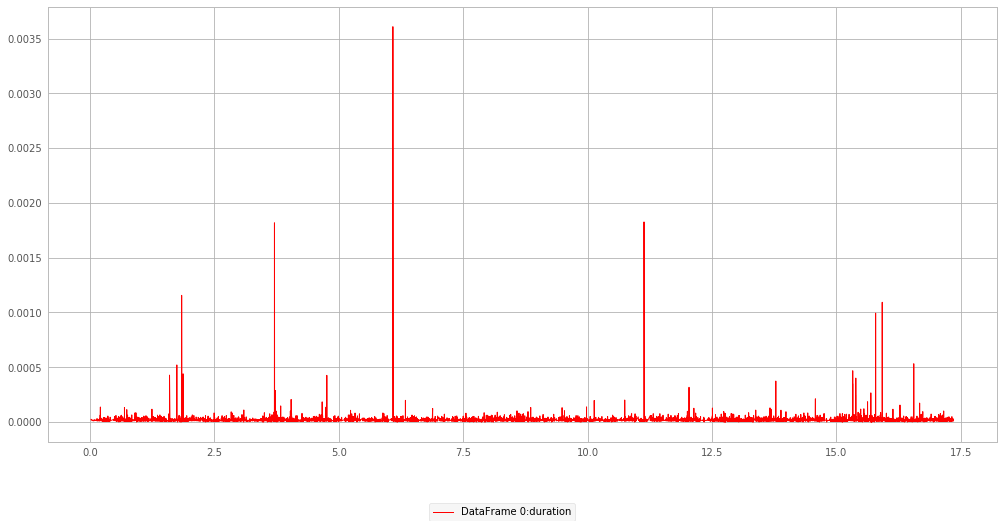

In [23]:
trappy.LinePlot(irq_stats_list, column=['duration']).view()

In [24]:
comm = "wget"
sched_switch_data_frame = trace.sched_switch.data_frame

comm_sched_in = sched_switch_data_frame[sched_switch_data_frame['next_comm'] == comm]
comm_sched_out = sched_switch_data_frame[sched_switch_data_frame['prev_comm'] == comm]

comm_sched_in = comm_sched_in[['__cpu']]
comm_sched_out = comm_sched_out[['__cpu']]

if len(comm_sched_in) > len(comm_sched_out):
    comm_sched_in.drop(comm_sched_in.index[len(comm_sched_in) - 1])
elif len(comm_sched_in) < len(comm_sched_out):
    comm_sched_out.drop(comm_sched_out.index[0], inplace=True)

comm_sched_running = comm_sched_in.copy()
comm_sched_running['start'] = comm_sched_in.index.values
comm_sched_running['end'] = comm_sched_out.index.values
comm_sched_running['duration'] = comm_sched_out.index.values - comm_sched_in.index.values

display(comm_sched_in.head())
display(comm_sched_out.head())
display(comm_sched_running.head())
display(comm_sched_running.describe())

__cpu
Time           
0.003527      0
0.006283      0
0.008965      0
0.011701      0
0.012488      0

__cpu
Time           
0.005363      0
0.008954      0
0.010624      0
0.011927      0
0.012884      0

__cpu     start       end  duration
Time                                         
0.003527      0  0.003527  0.005363  0.001836
0.006283      0  0.006283  0.008954  0.002671
0.008965      0  0.008965  0.010624  0.001659
0.011701      0  0.011701  0.011927  0.000226
0.012488      0  0.012488  0.012884  0.000396

__cpu         start           end      duration
count  19220.000000  19220.000000  19220.000000  19220.000000
mean       0.326379      9.226831      9.226931      0.000099
std        0.468900      5.086711      5.086704      0.000274
min        0.000000      0.003527      0.005363      0.000002
25%        0.000000      4.721950      4.722011      0.000016
50%        0.000000      9.674505      9.674517      0.000043
75%        1.000000     13.732581     13.732618      0.000110
max        1.000000     17.350703     17.351979      0.023788

In [25]:
domain_start = sys.maxint
domain_end = 0

domain = [domain_start, domain_end]

events = defaultdict()
number_of_cpus = comm_sched_in['__cpu'].unique().tolist()

In [26]:
for start in comm_sched_in.index.values:
    domain_start = min(domain_start, start)
for end in comm_sched_out.index.values:
    domain_end = max(domain_end, end)

domain = [domain_start, domain_end]

comm_sched_running['__cpu'] = \
    comm_sched_running['__cpu'].apply(lambda cpu: 'CPU Sched ' + str(int(cpu)))

comm_sched_events = comm_sched_running[['start', 'end', '__cpu']].values.tolist()
events[comm] = comm_sched_events

comm_sched_running.head()

__cpu     start       end  duration
Time                                               
0.003527  CPU Sched 0  0.003527  0.005363  0.001836
0.006283  CPU Sched 0  0.006283  0.008954  0.002671
0.008965  CPU Sched 0  0.008965  0.010624  0.001659
0.011701  CPU Sched 0  0.011701  0.011927  0.000226
0.012488  CPU Sched 0  0.012488  0.012884  0.000396

In [27]:
device_irq_stats = irq_stats_dict[19]

for start in device_irq_stats['start']:
    domain_start = min(domain_start, start)
for end in device_irq_stats['end']:
    domain_end = max(domain_end, end)

domain = [domain_start, domain_end]

device_irq_stats['__cpu'] = \
    device_irq_stats['__cpu'].apply(lambda cpu: 'CPU IRQ '  + str(int(cpu)))

device_irq_events = device_irq_stats[['start', 'end', '__cpu']].values.tolist()
events['irq'] = device_irq_events

device_irq_stats.head()

__comm      __cpu  __line  __pid  irq    name     start       end  \
Time                                                                          
0.022756   <...>  CPU IRQ 1     230    611   19  enp0s3  0.022756  0.022780   
0.023110   <...>  CPU IRQ 1     237    611   19  enp0s3  0.023110  0.023130   
0.041152  <idle>  CPU IRQ 1     575      0   19  enp0s3  0.041152  0.041173   
0.042414   <...>  CPU IRQ 1     596    611   19  enp0s3  0.042414  0.042426   
0.052070  <idle>  CPU IRQ 1     712      0   19  enp0s3  0.052070  0.052086   

          duration  
Time                
0.022756  0.000024  
0.023110  0.000020  
0.041152  0.000021  
0.042414  0.000012  
0.052070  0.000016

In [28]:
lanes_list = comm_sched_running['__cpu'].unique().tolist()
lanes_list = lanes_list + device_irq_stats['__cpu'].unique().tolist()

trappy.EventPlot(events, \
                 ['start', 'end', 'cpu'], \
                 domain=domain, \
                 lanes=lanes_list, lane_prefix='CPU', \
                 num_lanes=len(lanes_list)).view()
